In [1]:
!nvidia-smi

Sat May 21 09:38:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Image Retrieval image-based using HoG features and pre-trained model VGG16

In [2]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import  Model
from scipy.spatial import distance
from PIL import Image
from skimage import feature
from google.colab import files
import pickle
import numpy as np
import math
import os
import matplotlib.pyplot as plt
import matplotlib
import cv2 as cv
import time

In [3]:
!pip install --upgrade --no-cache-dir gdown

In [4]:
!gdown --id 1VdicuemXgiHdHute2S6xg2lgHpye4iZB
!unzip VizWiz.zip
!rm VizWiz.zip

Streaming output truncated to the last 5000 lines.
  inflating: txt/24199.txt           
  inflating: txt/24200.txt           
  inflating: txt/24201.txt           
  inflating: txt/24202.txt           
  inflating: txt/24203.txt           
  inflating: txt/24204.txt           
  inflating: txt/24205.txt           
  inflating: txt/24206.txt           
  inflating: txt/24207.txt           
  inflating: txt/24208.txt           
  inflating: txt/24209.txt           
  inflating: txt/24210.txt           
  inflating: txt/24211.txt           
  inflating: txt/24212.txt           
  inflating: txt/24213.txt           
  inflating: txt/24214.txt           
  inflating: txt/24215.txt           
  inflating: txt/24216.txt           
  inflating: txt/24217.txt           
  inflating: txt/24218.txt           
  inflating: txt/24219.txt           
  inflating: txt/24220.txt           
  inflating: txt/24221.txt           
  inflating: txt/24222.txt           
  inflating: txt/24223.txt           

In [5]:
def colorH2gram(pathfilename):
    img = cv.imread(pathfilename,cv.IMREAD_COLOR)
    img = cv.cvtColor(img,cv.COLOR_BGR2HSV)
    H, S, V = img[:,:,0], img[:,:,1], img[:,:,2]
    hist_h = cv.calcHist([H],[0],None,[256],[0,256])
    hist_s = cv.calcHist([S],[0],None,[256],[0,256])
    hist_v = cv.calcHist([V],[0],None,[256],[0,256])
    features = np.concatenate([hist_h,hist_s,hist_v])
    return features

def HoG(path_img):
    img = cv.imread(path_img)
    img = cv.resize(img, (75, 100))
    (hog, hog_image) = feature.hog(img, orientations=9, pixels_per_cell=(8, 8),
                                   cells_per_block=(2, 2), block_norm='L2-Hys',
                                   visualize=True, transform_sqrt=True)
    return hog

def processing(path, query_h2g ,mode = 0, verbose=0): # 0: h2g | 1: HoG
    results = []

    for item in os.listdir(path):
        if item == path.split('/')[-1]: # Remove query image
            continue
        if verbose != 0:
            print(f'Processing {item}')
        if mode == 0:
            data_h2g = colorH2gram(os.path.join(path,item))
        elif mode == 1:
            data_h2g = HoG(os.path.join(path,item))
        dist = 1 - distance.cosine(query_h2g, data_h2g)
        results.append([os.path.join(path,item), dist])

    results = np.array(results)
    return results

# Using color histogram

Query Image

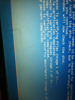

In [6]:
img_query = '/content/img/23455.png'
Image.open(img_query)

In [7]:
path = '/content/img'
start = time.time()
query_h2g = colorH2gram(img_query)
results = processing(path,query_h2g ,0)
print(f'Time used: {time.time()-start}s')

Time used: 2.7075107097625732s


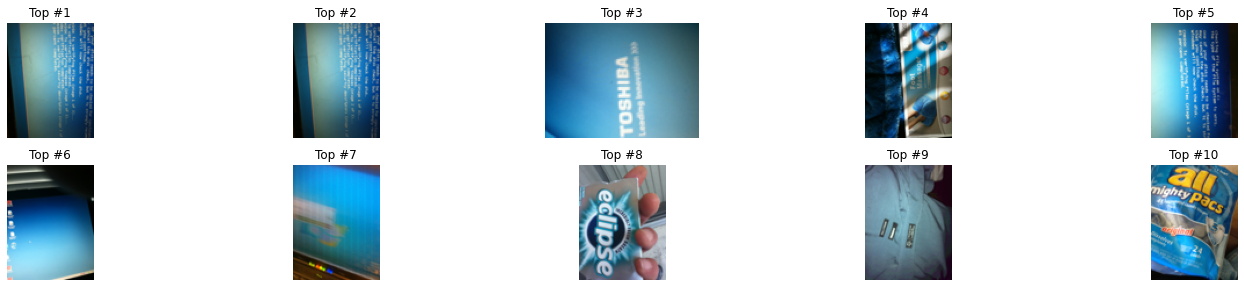

In [8]:
K = 10 # Return top K image same as query image 
results = sorted(results, key=lambda x: x[1],reverse=True)

axes = []
grid_size = int(math.sqrt(K))
fig = plt.figure(figsize=(20,10))


for id in range(K):
    draw_image = results[id]
    axes.append(fig.add_subplot(5, 5, id+1))
    # axes[-1].set_title(draw_image[0].split('/')[-1] + f' ({draw_image[1]})')
    axes[-1].set_title(f'Top #{id+1}')
    plt.axis('off')
    plt.imshow(Image.open(draw_image[0]))

fig.tight_layout()
plt.show()

# Using HoG

In [9]:
path = '/content/img'
start = time.time()
query_h2g = HoG(img_query)
results = processing(path, query_h2g , 1)
print(f'Time used: {time.time()-start}s')

Time used: 87.80959558486938s


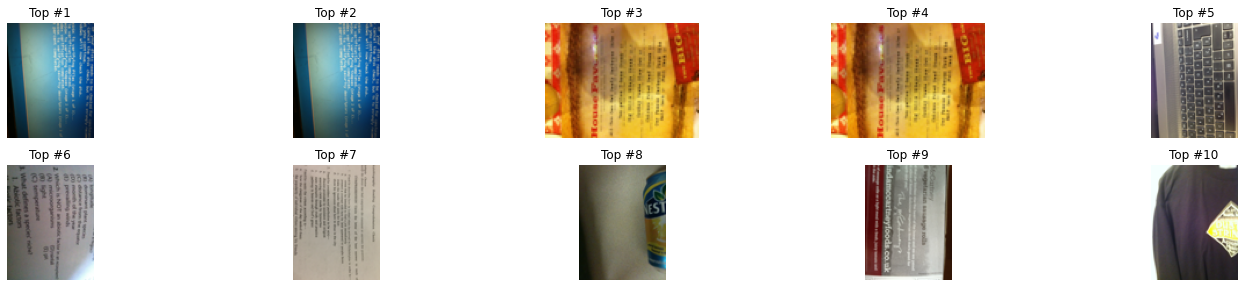

In [10]:
K = 10 # Return top K image same as query image 
# results = results[np.argsort(results[:, 1])] # Desending distance
results = sorted(results, key=lambda x: x[1], reverse=True)

axes = []
grid_size = int(math.sqrt(K))
fig = plt.figure(figsize=(20,10))

for id in range(K):
    draw_image = results[id]
    axes.append(fig.add_subplot(5, 5, id+1))
    # axes[-1].set_title(draw_image[0].split('/')[-1] + f' ({draw_image[1]})')
    axes[-1].set_title(f'Top #{id+1}')
    plt.axis('off')
    plt.imshow(Image.open(draw_image[0]))

fig.tight_layout()
plt.show()

# Using VGG16

In [12]:
# Model Defining
def get_extract_model():
    vgg16_model = VGG16(weights="imagenet")
    extract_model = Model(inputs=vgg16_model.inputs, outputs = vgg16_model.get_layer("fc1").output)
    return extract_model

# Image Preprocessing, image to tensor
def image_preprocess(img):
    img = img.resize((224,224)) # VGG16 constraint
    img = img.convert("RGB")
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

def extract_vector(model, image_path, verbose=0):
    if verbose != 0:
        print("Extracting: ", image_path)
    img = Image.open(image_path)
    img_tensor = image_preprocess(img)

    # Features extraction
    vector = model.predict(img_tensor)[0]
    # Vector normalization
    vector = vector / np.linalg.norm(vector)
    return vector

In [13]:
# Model initialization
model = get_extract_model()

data_path = '/content/img'

vectors, paths = [], []

for image_path in os.listdir('img'):
    # Full path of images
    image_path_full = os.path.join(data_path, image_path)
    # Image's feature extraction
    image_vector = extract_vector(model,image_path_full)
    # Store features and path to list
    vectors.append(image_vector)
    paths.append(image_path_full)

# Save feature's file
vector_file = "vectors.pkl"
path_file = "paths.pkl"

pickle.dump(vectors, open(vector_file, "wb"))
pickle.dump(paths, open(path_file, "wb"))

553476096/553467096 [==============================] - 2s 0us/step


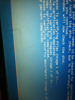

In [14]:
img_query = '/content/img/23455.png'
Image.open(img_query)

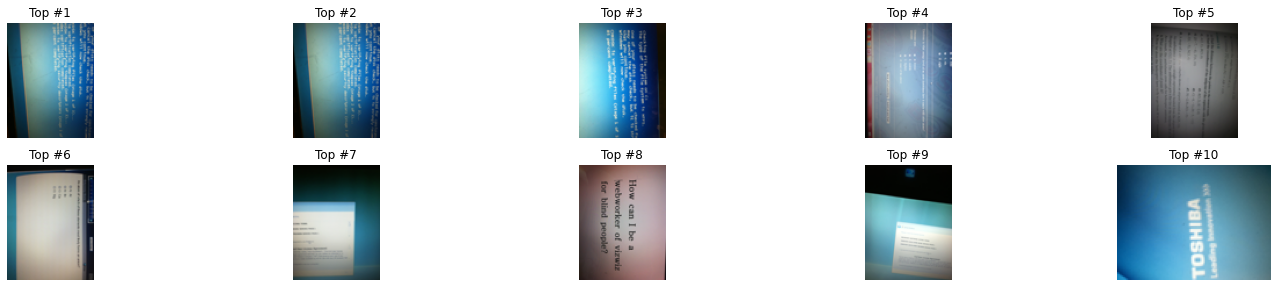

In [15]:
# Query image features extraction
search_vector = extract_vector(model, img_query)

vectors = pickle.load(open("vectors.pkl","rb"))
paths = pickle.load(open("paths.pkl","rb"))

# Distance from query's vector to all vector in dataset
distance = np.linalg.norm(vectors - search_vector, axis=1)

K = 10 # Return top K image same as query image 
ids = np.argsort(distance)[:K]

nearest_image = [(paths[id], distance[id]) for id in ids]

axes = []
grid_size = int(math.sqrt(K))
fig = plt.figure(figsize=(20,10))


for id in range(K):
    draw_image = nearest_image[id]
    # axes.append(fig.add_subplot(grid_size, grid_size, id+1))
    axes.append(fig.add_subplot(5, 5, id+1))


    # axes[-1].set_title(draw_image[1])
    # axes[-1].set_title(draw_image[0].split('/')[-1] + f' ({draw_image[1]})')
    axes[-1].set_title(f'Top #{id+1}')

    plt.axis('off')
    plt.imshow(Image.open(draw_image[0]))

fig.tight_layout()
plt.show()

Save to drive for further purposes

In [17]:
!cp /content/paths.pkl /content/drive/MyDrive/CS336.M12.KHCL/results
!cp /content/vectors.pkl /content/drive/MyDrive/CS336.M12.KHCL/results